**Compared to traditional RAG, multimodal data presents greater challenges, as the data includes text, tables, and images. There are three main processing approaches:**

------

### 1. **Based on Multimodal Embedding Models**

*Low cost, relies on embedding models for similarity-based retrieval*

- Use multimodal embedding models (e.g., OpenAI CLIP, Alibaba multimodal-embedding-v1) to embed both images and text
- Retrieve both images and text through similarity search
- Feed the retrieved raw images and text chunks into a multimodal large model for answer generation

------

### 2. **Based on Multimodal Large Models (Image-to-Text Summary First)**

*Moderate cost, relies on the model’s visual understanding ability*

- Use a multimodal large model to generate textual summaries from images
- Perform embedding and retrieval on the generated text
- Feed the retrieved text chunks into a large model to synthesize the answer

------

### 3. **Based on Multimodal Large Models (With Image Re-Inference)**

*Slow and costly, but enables context-aware image re-understanding at generation*

- Use a multimodal large model to generate image summaries
- Perform embedding and retrieval on the summaries, while keeping references to the original images
- Feed both the original images and retrieved text into a multimodal large model to generate the final answer




I have now successfully reproduced the code based on the **Multimodal Embedding Models** approach from the case study. Next, I plan to switch the model to **`google/medgemma-4b-it`** and integrate it into the RAG pipeline for model evaluation.

In [1]:
from dotenv import load_dotenv
import os
import shutil

# 加载环境配置文件
_ = load_dotenv()

# 请将此路径替换为你的目录
BASE_DIR  = r"E:\AI\masterThesis\code\RAG\source"

#资源地址
RESOURCE_DIR = BASE_DIR+ '\\resources'

# 工具地址
TOOLS_DIR = BASE_DIR + '\\tools'


#图片提取地址
IMAGE_OUT_DIR = RESOURCE_DIR + '\\images'


#pdf 地址
PDF_PATH = RESOURCE_DIR + "\\978-7-5170-2271-8_1.pdf"

print(f"PDF_PATH:{PDF_PATH}")

RESIZE_IMAGE_DIR = RESOURCE_DIR+"\\temp"



PDF_PATH:E:\AI\masterThesis\code\RAG\source\resources\978-7-5170-2271-8_1.pdf


In [2]:
!where pdfinfo

D:\software\AI\Release-24.08.0-0\poppler-24.08.0\Library\bin\pdfinfo.exe


In [3]:
os.environ['path'] += os.pathsep + os.path.join(TOOLS_DIR,'poppler-24.08.0\Library\bin') 

!pdfinfo -v  
# pdfinfo version 24.08.0

pdfinfo version 24.08.0
Copyright 2005-2024 The Poppler Developers - http://poppler.freedesktop.org
Copyright 1996-2011, 2022 Glyph & Cog, LLC


In [4]:
os.environ['path'] += os.pathsep + os.path.join(TOOLS_DIR,'Tesseract-OCR')

!tesseract -v

 # tesseract v5.5.0.20241111

tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


In [5]:
import nltk
print(nltk.data.path)

['C:\\Users\\mrwil/nltk_data', 'd:\\software\\AI\\Anaconda3\\envs\\langchain\\nltk_data', 'd:\\software\\AI\\Anaconda3\\envs\\langchain\\share\\nltk_data', 'd:\\software\\AI\\Anaconda3\\envs\\langchain\\lib\\nltk_data', 'C:\\Users\\mrwil\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [6]:
import  os
# os.environ['HF_ENDPOINT']='https://hf-mirror.com'
from unstructured.partition.pdf import partition_pdf
import logging
logging.basicConfig(level=logging.INFO)


# 如果图片提取目录存在则删除重建
if os.path.exists(IMAGE_OUT_DIR):
     shutil.rmtree(IMAGE_OUT_DIR)
os.makedirs(IMAGE_OUT_DIR)

pdf_data = partition_pdf(
    filename=PDF_PATH,
    extract_images_in_pdf=True, #提取图片
    infer_table_structure=True,    # 启用表格结构识别
    max_characters=4000,          # 每个文本块最大字符数
    new_after_n_chars=3800,       # 达到3800字符后分新块
    combine_text_under_n_chars=2000, # 合并小于2000字符的文本块
    chunking_strategy = "by_title", # 按标题分块
    extract_image_block_output_dir=IMAGE_OUT_DIR, #图片提取路径
)


d:\software\AI\Anaconda3\envs\langchain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:pikepdf._core:pikepdf C++ to Python logger bridge initialized
INFO:unstructured_inference:Reading PDF for file: E:\AI\masterThesis\code\RAG\source\resources\978-7-5170-2271-8_1.pdf ...
INFO:unstructured_inference:Loading the Table agent ...
INFO:unstructured_inference:Loading the table structure model ...
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
Some weights of the

In [7]:
print(pdf_data)#  ===> 【CompositeElement ，table，CompositeElement ，table】
print("="*100)
print(pdf_data[0].metadata.orig_elements) # 查看 CompositeElement （子节点）

print("="*100)
print(pdf_data[0].metadata.orig_elements[1]) # 查看 CompositeElement 的子节点

[<unstructured.documents.elements.CompositeElement object at 0x0000020905ED6350>, <unstructured.documents.elements.CompositeElement object at 0x0000020905ED5150>, <unstructured.documents.elements.CompositeElement object at 0x0000020905ED4BD0>, <unstructured.documents.elements.Table object at 0x0000020905EACD90>, <unstructured.documents.elements.CompositeElement object at 0x0000020905ED6AD0>, <unstructured.documents.elements.Table object at 0x0000020905ED54D0>, <unstructured.documents.elements.CompositeElement object at 0x0000020905ED1050>, <unstructured.documents.elements.Table object at 0x0000020905DCE2D0>, <unstructured.documents.elements.CompositeElement object at 0x0000020905F2C390>, <unstructured.documents.elements.CompositeElement object at 0x0000020905ED32D0>, <unstructured.documents.elements.CompositeElement object at 0x0000020905F31C90>, <unstructured.documents.elements.CompositeElement object at 0x0000020905F3E2D0>, <unstructured.documents.elements.CompositeElement object at 

In [8]:
from unstructured.documents.elements import Table,CompositeElement

tables = []
texts = []

for element in pdf_data:
    if isinstance(element,Table):
        tables.append(str(element))
    elif isinstance(element,CompositeElement):
        texts.append(str(element))

In [9]:
print(f"表格元素：{len(tables)} \n文本元素：{len(texts)}")

表格元素：4 
文本元素：14


In [10]:
# 如果使用OpenAI的Clip模型，需要安装依赖：
# pip install langchain-experimental open_clip_torch torch -i https://pypi.tuna.tsinghua.edu.cn/simple
from langchain_experimental.open_clip import OpenCLIPEmbeddings
# OpenCLIPEmbeddings()

# langchain中暂无其他多模态嵌入的实现，实现自己的阿里多模态嵌入
# https://bailian.console.aliyun.com/?tab=api#/api/?type=model&url=https%3A%2F%2Fhelp.aliyun.com%2Fdocument_detail%2F2712517.html&renderType=iframe
from typing import List

from langchain_community.embeddings.dashscope import DashScopeEmbeddings
from langchain_core.embeddings import Embeddings
from pydantic import BaseModel
import dashscope


class MultiDashScopeEmbeddings(BaseModel, Embeddings):

    '''多模态嵌入模型'''
    model: str = "multimodal-embedding-v1"

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        text_features = []
        for text in texts:
            resp = dashscope.MultiModalEmbedding.call(
                model=self.model,
                input= [{'text': text}]
            )
            embeddings_list = resp.output['embeddings'][0]['embedding']
            text_features.append(embeddings_list)
        return text_features

    def embed_query(self, text: str) -> List[float]:
        resp = dashscope.MultiModalEmbedding.call(
            model=self.model,
            input= [{'text': text}]
        )
        embeddings_list = resp.output['embeddings'][0]['embedding']
        return embeddings_list
    
    def embed_image(self, uris: List[str]) -> List[List[float]]:
        image_features = []
        for uri in uris:
            # 阿里dashscope SDK要求传递图片的地址，对于本地图片dashscope SDK会将图片上传到OSS服务中：
            local_image_uri = f"file://{uri}"
            resp = dashscope.MultiModalEmbedding.call(
                model=self.model,
                input=[{"image":local_image_uri}]
            )
            embeddings_list = resp.output['embeddings'][0]['embedding']
            print(f"{uri} 图片向量 {resp.status_code}：{embeddings_list[:3]}")
            image_features.append(embeddings_list)
        return image_features


In [12]:
import os
from langchain_chroma import Chroma

from langchain_core.documents import Document

import dashscope
dashscope.api_key ="sk-1d61e62259034aaaaf7f1d66fca779c8"


vectorstore = Chroma(
    collection_name="multi-vector", 
    # persist_directory=r"F:\AI\L2\Advanced-RAG\source\db", # 持久化存储路径
    embedding_function= MultiDashScopeEmbeddings()
)



# 获得图片的地址
image_uris = sorted(
    [
        os.path.join(IMAGE_OUT_DIR, image_name)
        for image_name in os.listdir(IMAGE_OUT_DIR)
        if image_name.endswith(".jpg")
    ]
)

# 添加图片 （存储图像base64数据与其向量数据） 
vectorstore.add_images(uris=image_uris)    # embedding_function 向量化


# 添加文本与表格
vectorstore.add_documents([Document(page_content=table) for table in tables])  # embedding_function 向量化
vectorstore.add_documents([Document(page_content=text) for text in texts])

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})


E:\AI\masterThesis\code\RAG\source\resources\images\figure-1-1.jpg 图片向量 200：[0.01968494802713394, 0.0076696802861988544, 0.015384509228169918]
E:\AI\masterThesis\code\RAG\source\resources\images\figure-12-9.jpg 图片向量 200：[0.01522250659763813, 0.016220515593886375, 0.001269020140171051]
E:\AI\masterThesis\code\RAG\source\resources\images\figure-13-10.jpg 图片向量 200：[0.015502599067986012, 0.013917888514697552, -0.0016622231341898441]
E:\AI\masterThesis\code\RAG\source\resources\images\figure-14-11.jpg 图片向量 200：[0.01621624268591404, 0.027511198073625565, -0.012939385138452053]
E:\AI\masterThesis\code\RAG\source\resources\images\figure-14-12.jpg 图片向量 200：[-0.01880875788629055, -0.01028158888220787, -0.01987963728606701]
E:\AI\masterThesis\code\RAG\source\resources\images\figure-14-13.jpg 图片向量 200：[0.01486346498131752, 0.01415680255740881, -0.009928605519235134]
E:\AI\masterThesis\code\RAG\source\resources\images\figure-18-14.jpg 图片向量 200：[0.012821930460631847, 0.01046158466488123, -0.00740098

In [13]:
# 检索分块后的数据
retriever.invoke("手电筒电路图")

[Document(id='49b3b37b-cf27-4c3e-9286-dfc28600cb6e', metadata={}, page_content='元件\n\n元件'),
 Document(id='dbdea6cd-6f45-4db5-964f-60d36de94ce8', metadata={}, page_content='4A a 6A d c 4A a 6A d c a 6A 20 5 20 5 20 5 + + + + + + 140V - 6 10A 90V - 140V - 6 b 10A 90V - 140V - 6 10A 90V - b b （a）原电路 （b）选 b 点为参考点 （c）选 d 点为参考点 图 1.30 电位计算示例 d'),
 Document(id='bee4b560-e5a5-40f3-a643-249918564d20', metadata={}, page_content='I=2A I[=-2A I=-2A Ta | a Tol ° A oO ° B O ° Cc o + U=5V + U=5SV + U=5V (a) (b) Co)'),
 Document(id='a9dad1b4-5a79-44e1-84bd-8e2a79f6c42c', metadata={}, page_content='（a）关联参考方向 （b）非关联参考方向'),
 Document(id='bb0057e3-5e88-4c5d-9645-2841b802d20f', metadata={}, page_content='a b a + u - u （a） （b）'),
 Document(id='daf022b5-71c0-4182-99ae-0686f29b1f43', metadata={}, page_content='N U\n\n（1）电源的额定电流 IN；\n\n（2）电源的开路电压 UOC；\n\n（3）电源在额定工作情况下的负载电阻 RN；\n\n（4）负载发生短路时的短路电流 ISC。\n\nI\n\n   +      U      -         S1   A      S2   M      R0     +   US     -   +      U      -   S   R   图 1.

In [14]:
### 五、RAG构建
import io
from PIL import Image
import uuid 
import base64
import os


if os.path.exists(RESIZE_IMAGE_DIR):
    shutil.rmtree(RESIZE_IMAGE_DIR)
os.makedirs(RESIZE_IMAGE_DIR)

'''
缩放图片

注意：如果是OpenAI需要传递图片base64：
    {"type": "text","text":"需求" }
    {"type": "image_url","image_url":{"url":f"data:image/jpeg:base64,{base64_image_data}"} }
而ChatTongyi是对阿里DashScope SDK的封装，既可以传递图片的base64
https://bailian.console.aliyun.com/?tab=doc#/api/?type=model&url=https%3A%2F%2Fhelp.aliyun.com%2Fdocument_detail%2F2845871.html
    {"text": "需求"},{"image":f"data:image/jpeg:base64,{base64_image_data}"}}

也可以传递图片的地址，如果传递本地图片地址，阿里SDK会将图片上传到OSS服务中：
    {"text": "需求"},{"image":f"file://{图片的绝对地址}"}  
'''
def resize_base64_image4tongyi(base64_string, max_size=(640, 480)):
    # 解析图片
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    width, height = img.size
    ratio = max(max_size[0] / width, max_size[1] / height)
     # 计算按比例缩放后的宽高
    new_width = int(width * ratio)
    new_height = int(height * ratio)

    # 缩放
    resized_img = img.resize((new_width,new_height), Image.LANCZOS)

    # 保存图片到指定路径
    out_path = os.path.join(RESIZE_IMAGE_DIR,str(uuid.uuid4())+ ".jpg")
    resized_img.save(out_path)
    # 图片地址
    return out_path


"""检查是否为base64数据：图片"""
def is_base64(s):
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """缩放图片（防止图片过大，超过多模态大模型的窗口限制）"""
    images = []
    text = []
    for doc in docs:
        content = doc.page_content 
        if is_base64(content):
            # 缩放图片
            resize_image = resize_base64_image4tongyi(content)
            images.append(resize_image) 
        else:
            text.append(content)
    return {"images": images, "texts": text}

In [15]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_community.chat_models.tongyi import ChatTongyi


def prompt_func(data_dict):
    # "context":{"images": ["缩放后的图片地址","缩放后的图片地址"], "texts": "doc1"}
    # 提取图片与文本
    images = data_dict["context"]["images"]
    texts = data_dict["context"]["texts"]

    messages = []
    # 装载图片数据
    for image in images:
        messages.append(
            HumanMessage(
                content=[
                    {"text":f"请将图片标记标注为：`{image}`"}, 
                    {"image":f"file://{image}"}
                ]
            )
        )
    
     # 装载文本数据
    formatted_texts = "\n\n".join(texts)


    # 该提示词可优化，如加入少量样本，让大模型输出更稳定
    messages.append(
        HumanMessage(content=[
                {
                    "text": 
                    "你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。"
                    "你将获得相关的图片与文本作为参考的上下文。这些图片和文本都是根据用户输入的关键词从向量数据库中检索获取的。"
                    "请根据提供的图片和文本结合你丰富的知识与分析能力，提供一份全面的问题解答。"
                    "请将提供的图片标记自然融入答案阐述的对应位置进行合理排版，答案中提及的图片统一以`<image>传递的图片真实标记</image>`的形式呈现。\n\n"
                    f"用户的问题是：{data_dict['question']}\n\n"
                    "参考的文本或者表格数据：\n"
                    f"{formatted_texts}"
                }
            ]
        )
    )
    return messages


# 千问视觉模型（多模态）
llm = ChatTongyi(model="qwen-vl-max",dashscope_api_key="sk-1d61e62259034aaaaf7f1d66fca779c8") 
# 可以传base64数据，可以传图片url地址，也可以传图片本地路径

# RAG pipeline
chain = (
    {
        "question": RunnablePassthrough(),
        "context": retriever | RunnableLambda(split_image_text_types)
    }
    | RunnableLambda(prompt_func)
    | llm
    | StrOutputParser()
)

In [16]:
retriever.invoke("手电筒的电路模型")

[Document(id='dbdea6cd-6f45-4db5-964f-60d36de94ce8', metadata={}, page_content='4A a 6A d c 4A a 6A d c a 6A 20 5 20 5 20 5 + + + + + + 140V - 6 10A 90V - 140V - 6 b 10A 90V - 140V - 6 10A 90V - b b （a）原电路 （b）选 b 点为参考点 （c）选 d 点为参考点 图 1.30 电位计算示例 d'),
 Document(id='49b3b37b-cf27-4c3e-9286-dfc28600cb6e', metadata={}, page_content='元件\n\n元件'),
 Document(id='bee4b560-e5a5-40f3-a643-249918564d20', metadata={}, page_content='I=2A I[=-2A I=-2A Ta | a Tol ° A oO ° B O ° Cc o + U=5V + U=5SV + U=5V (a) (b) Co)'),
 Document(id='a9dad1b4-5a79-44e1-84bd-8e2a79f6c42c', metadata={}, page_content='（a）关联参考方向 （b）非关联参考方向'),
 Document(id='bb0057e3-5e88-4c5d-9645-2841b802d20f', metadata={}, page_content='a b a + u - u （a） （b）'),
 Document(id='332c8d22-98c4-464c-af9f-ba28d49410e4', metadata={}, page_content='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMj

In [ ]:
# chain = (
#     {
#         "question": RunnablePassthrough(),
#         "context": retriever | RunnableLambda(split_image_text_types)   # "context":{"images": ["图片地址","图片地址"], "texts": "doc1"}
#     }| RunnableLambda(prompt_func)
# )

# chain.invoke("手电筒的电路模型")

[HumanMessage(content=[{'text': '请将图片标记标注为：`E:\\AI\\masterThesis\\code\\RAG\\AGI大模型全栈班-L2阶段\\11-多模态图文检索RAG实战1，多模态向量模型方案-25.4.25\\source\\resources\\temp\\e96a5a14-976a-4a6a-a4e1-57a97bc7b91e.jpg`'}, {'image': 'file://E:\\AI\\masterThesis\\code\\RAG\\AGI大模型全栈班-L2阶段\\11-多模态图文检索RAG实战1，多模态向量模型方案-25.4.25\\source\\resources\\temp\\e96a5a14-976a-4a6a-a4e1-57a97bc7b91e.jpg'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'text': '请将图片标记标注为：`E:\\AI\\masterThesis\\code\\RAG\\AGI大模型全栈班-L2阶段\\11-多模态图文检索RAG实战1，多模态向量模型方案-25.4.25\\source\\resources\\temp\\53f7f9ef-e6c0-4a3d-9132-2dbab9ecf57c.jpg`'}, {'image': 'file://E:\\AI\\masterThesis\\code\\RAG\\AGI大模型全栈班-L2阶段\\11-多模态图文检索RAG实战1，多模态向量模型方案-25.4.25\\source\\resources\\temp\\53f7f9ef-e6c0-4a3d-9132-2dbab9ecf57c.jpg'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'text': '请将图片标记标注为：`E:\\AI\\masterThesis\\code\\RAG\\AGI大模型全栈班-L2阶段\\11-多模态图文检索RAG实战1，多模态向量模型方案-25.4.25\\source\\resources\\temp\\75f1cd9a-410


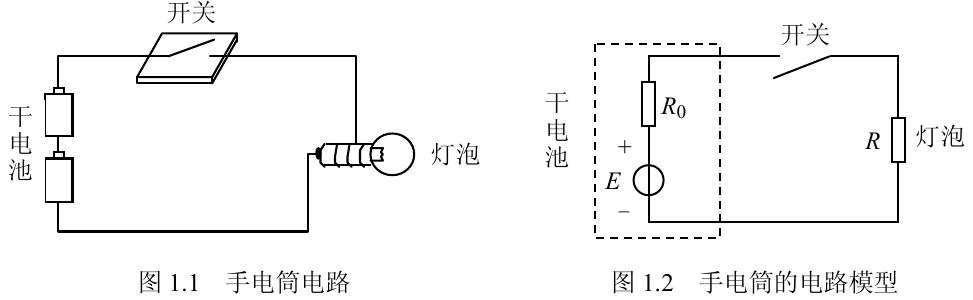


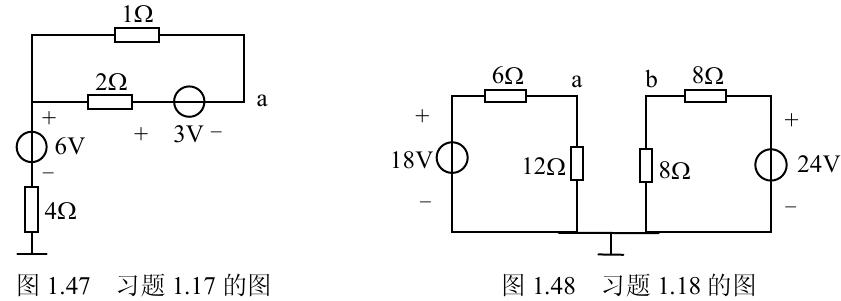


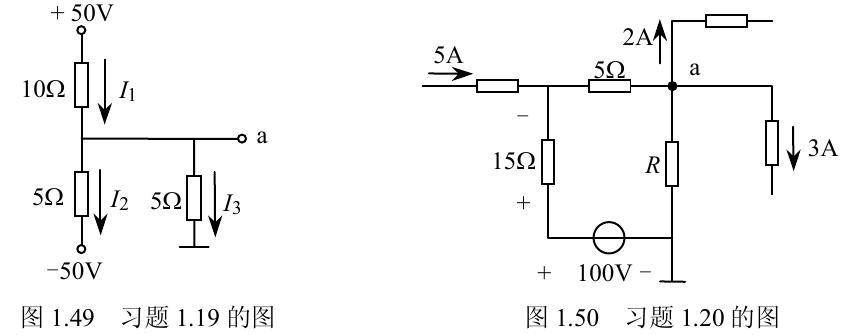


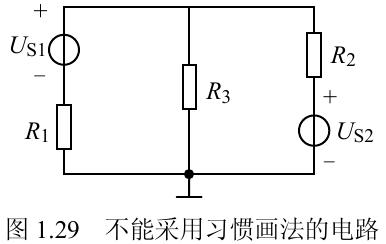


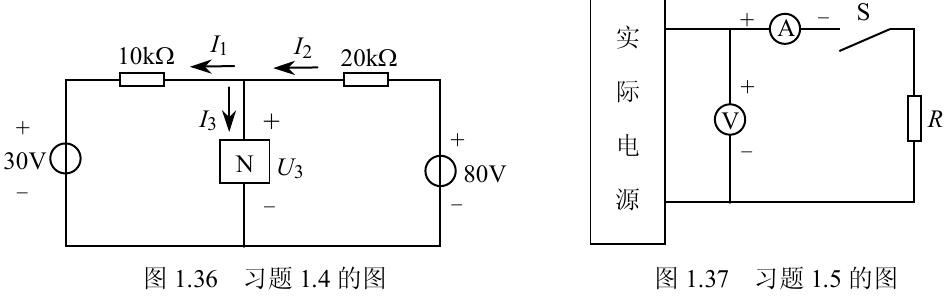

In [17]:
from IPython.display import HTML, display

#显示图片
def show_plt_img(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

query = "手电筒的电路模型"

docs = retriever.invoke(query)

for doc in docs:
    if is_base64(doc.page_content):
        # print(doc.page_content)
        show_plt_img(doc.page_content)

In [21]:
print(query)

print("\n-------------------")
result = chain.invoke(query)

print(result)

手电筒的电路模型

-------------------
为了回答关于“手电筒的电路模型”的问题，我们首先需要理解手电筒的基本工作原理及其电路模型。以下是对该问题的详细解答：

### 1. 手电筒的基本工作原理

手电筒是一种便携式照明工具，其基本工作原理是通过电池提供电能，经过开关控制，使电流通过灯泡（或LED），从而发光。

### 2. 手电筒的电路组成

手电筒的电路主要由以下部分组成：
- **电源（干电池）**：提供电能。
- **开关**：控制电路的通断。
- **灯泡（或LED）**：将电能转化为光能。
- **导线**：连接各元件，形成电流回路。

### 3. 手电筒的电路模型

电路模型是对实际电路的简化表示，便于分析和计算。对于手电筒，其电路模型可以表示为：

- **电源模型**：实际电源（干电池）可以用理想电压源和内阻串联来表示。
- **负载模型**：灯泡可以用一个电阻来表示其耗电特性。

### 4. 具体电路模型分析

根据提供的图片，我们可以具体分析手电筒的电路模型。

#### 图 1.1 手电筒电路（<image>E:\AI\masterThesis\code\RAG\source\resources\temp\7b53976b-a633-4eac-a9a1-aa400cdf5847.jpg</image>）

该图展示了手电筒的基本电路结构：
- **干电池**：作为电源。
- **开关**：控制电路的通断。
- **灯泡**：作为负载。

#### 图 1.2 手电筒的电路模型（<image>E:\AI\masterThesis\code\RAG\source\resources\temp\7b53976b-a633-4eac-a9a1-aa400cdf5847.jpg</image>）

该图进一步将手电筒的电路简化为电路模型：
- **干电池**：用理想电压源 \( E \) 和内阻 \( R_0 \) 串联来表示。
- **灯泡**：用电阻 \( R \) 来表示。

### 5. 电路模型的应用

电路模型可以帮助我们进行电路分析，例如计算电流、电压等参数。

- **电流计算**：根据欧姆定律 \( I = \frac{E}{R + R_0} \)，可以计算电路中的电流。
- **电压分配**：可以根据分压原


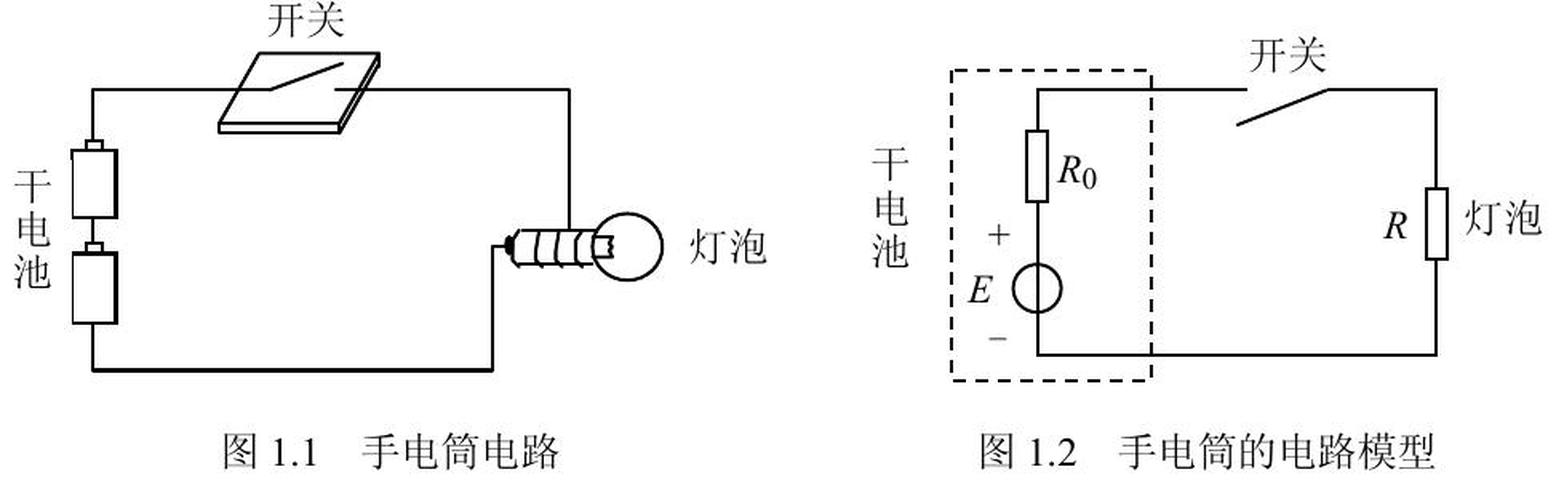


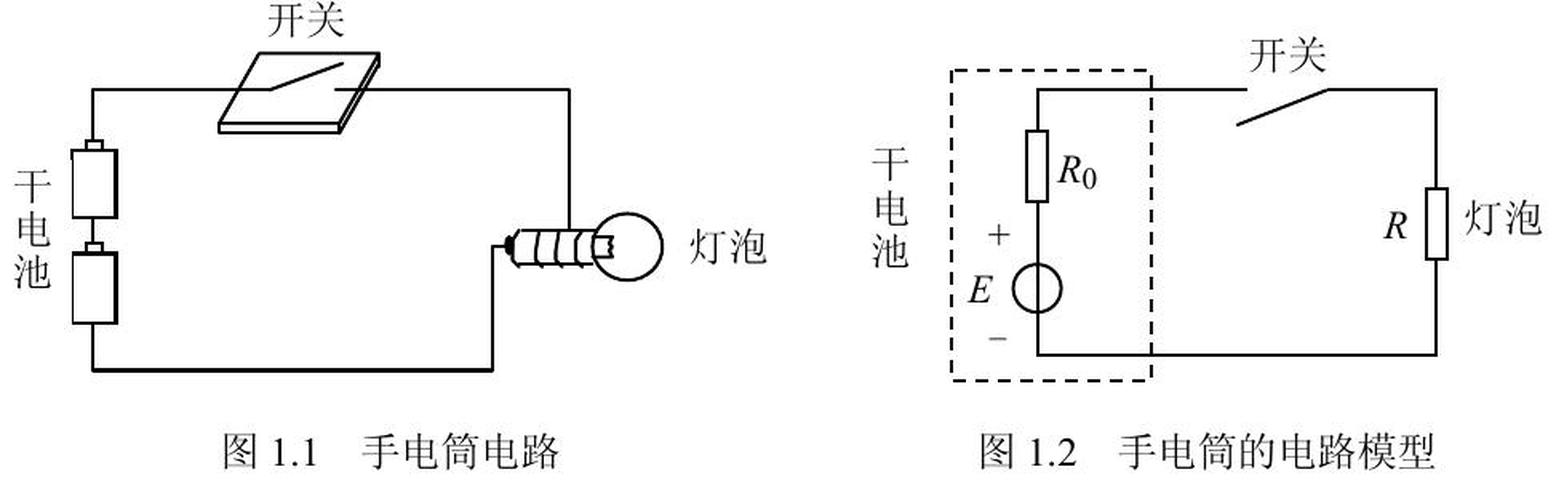

In [23]:
import base64
from IPython.display import HTML, display
import markdown

start_tag = "<image>"
end_tag = "</image>"


def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        img_data = img_file.read()
        img_base64 = base64.b64encode(img_data).decode('utf-8')
        return img_base64

def display_answer(text:str):
    # 根据<image>标签 分割文本：xxx<image>xxx</image> => ['xxx','xxx</image>'] 
    parts = text.split(start_tag)
    for part in parts:
        # 再根据</image>标签 分割文本：xxx => ['xxx'], xxx</image> => ['xxx','']
        chunks = part.split(end_tag)
        if len(chunks) > 1:
            # 存在图片
            image_path = chunks[0]
            context = chunks[1]
            img_base64 = encode_image(image_path)
            display(HTML(f'\n<img src="data:image/jpeg;base64,{img_base64}"/>\n'))
            display(HTML(markdown.markdown(context)))
        else:
            display(HTML(markdown.markdown(part)))

       
display_answer(result)